<a href="https://colab.research.google.com/github/comp0000/anguissola/blob/main/dual_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel inputs to a CNN for image classification

Below is a simple example of an image classification network that takes a second categorical input alongside the image data. Consider this a toy surrogate of the artist attribution problem where we anticipate tagging image swatches with metadata such as its subject matter.

## Setting Up

Just some standard imports.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Data

We'll combine two MNIST-type image sets to simulate two artists who produce comparable images, but who have different "styles" in each of 10 categories. Specifically:

* Artist 0 uses odd categories from MNIST and even from Fashion MNIST
* Artist 1 uses even categories from MNIST and odd from Fashion MNIST

So both artists produce all 10 categories, and each includes half of each dataset, but for any given category their images will be different and actually very easy to distinguish. (Arguably too easy, but this is only a demonstration of the concept.)

In [2]:
# load the two datasets
(digit_img_train, digit_cat_train), (digit_img_test, digit_cat_test) = tf.keras.datasets.mnist.load_data()
(fashion_img_train, fashion_cat_train), (fashion_img_test, fashion_cat_test) = tf.keras.datasets.fashion_mnist.load_data()

# combine the inputs of each type

# we add a channel dimension to images because the Conv2D layers want one
# and we also convert to float and scale into [0,1]
X_img_train = np.expand_dims(np.concatenate([digit_img_train, fashion_img_train]), -1).astype('float32') / 255
X_img_test = np.expand_dims(np.concatenate([digit_img_test, fashion_img_test]), -1).astype('float32') / 255

# we'll also one-hot encode our cats — it's possible we could get away with just
# a scalar for something ordinal like MNIST, but the Fashion MNIST classes are
# unordered and our future metadata (hair, eyes, clothes) probably will be too
X_cat_train = tf.keras.utils.to_categorical(np.concatenate([digit_cat_train, fashion_cat_train]), 10)
X_cat_test = tf.keras.utils.to_categorical(np.concatenate([digit_cat_test, fashion_cat_test]), 10)

# label the artists according to our schema
y_train = np.concatenate([(digit_cat_train % 2) == 0, (fashion_cat_train % 2) == 1])
y_test = np.concatenate([(digit_cat_test % 2) == 0, (fashion_cat_test % 2) == 1])

# check that we've got something sane out
display(X_img_train.shape, X_cat_train.shape, y_train.shape)

(120000, 28, 28, 1)

(120000, 10)

(120000,)

Let's have a quick look at some images.

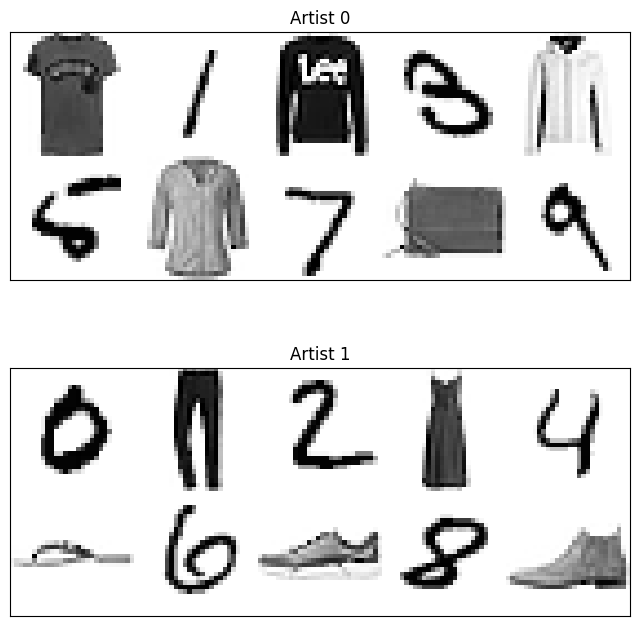

In [3]:
artist_0 = np.zeros((28 * 2, 28 * 5))
artist_1 = np.zeros((28 * 2, 28 * 5))

lab_test = np.concatenate([digit_cat_test, fashion_cat_test])

for rr in range(2):
  for cc in range(5):
    artist_0[(28 * rr):(28 * (rr + 1)), (28 * cc):(28 * (cc + 1))] = X_img_test[(y_test == 0) & (lab_test == rr * 5 + cc),:,:,:][0,:,:,0]
    artist_1[(28 * rr):(28 * (rr + 1)), (28 * cc):(28 * (cc + 1))] = X_img_test[(y_test == 1) & (lab_test == rr * 5 + cc),:,:,:][0,:,:,0]

fig = plt.figure(figsize=(8,8))
axs = fig.subplots(nrows=2)

axs[0].imshow(artist_0, cmap='Greys')
axs[1].imshow(artist_1, cmap='Greys')

for ii in range(2):
  axs[ii].set_xticklabels([])
  axs[ii].set_yticklabels([])
  axs[ii].set_xticks([])
  axs[ii].set_yticks([])
  axs[ii].set_title(f'Artist {ii}')

They're not all that alike, but it'll do.

## Model

Build a model using the Keras functional API. This is going to be very basic: a couple of convolutional layers with max pooling, and a fully connected classifier. The categorical input bypasses the convolutions and goes straight to the classifier. (More complex architectures are obviously possible.)

In [4]:
img_input = tf.keras.Input(shape=(28,28,1), name='image')
cat_input = tf.keras.Input(shape=(10,), name='category')

conv_1 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(img_input)
pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(pool_1)
pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
features = tf.keras.layers.Flatten()(pool_2)
combo = tf.keras.layers.concatenate([features, cat_input])
pred = tf.keras.layers.Dense(1, name='artist')(combo)

model = tf.keras.Model(inputs=[img_input, cat_input], outputs={'artist' : pred})

Let's just plot the structure to check it makes sense. (I wasn't sure if model plotting worked out of the box on Colab, but happily it does!)

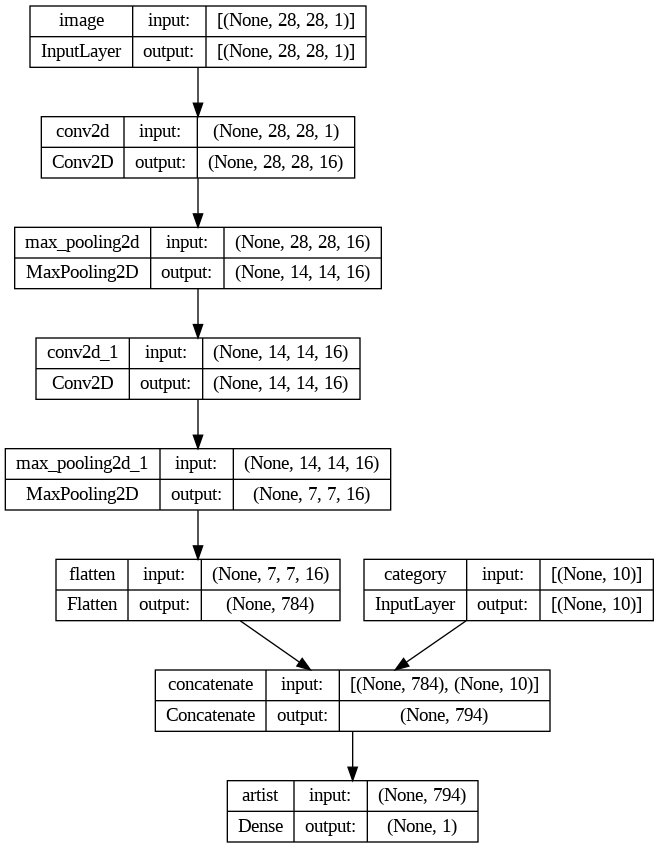

In [5]:
tf.keras.utils.plot_model(model, 'dual_input_model.png', show_shapes=True)

Ok, let's train this thing.

In [6]:
model.compile( optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'] )

history = model.fit( x = {'image' : X_img_train, 'category' : X_cat_train},
                     y = y_train,
                     validation_data = ( {'image' : X_img_test, 'category' : X_cat_test}, y_test ),
                     epochs=10,
                     batch_size=50,
                   )

Epoch 1/10
2400/2400 [==============================] - 18s 5ms/step - loss: 0.1579 - accuracy: 0.9342 - val_loss: 0.0956 - val_accuracy: 0.9672
Epoch 2/10
2400/2400 [==============================] - 10s 4ms/step - loss: 0.0794 - accuracy: 0.9707 - val_loss: 0.0751 - val_accuracy: 0.9692
Epoch 3/10
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0631 - accuracy: 0.9770 - val_loss: 0.0598 - val_accuracy: 0.9772
Epoch 4/10
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0532 - accuracy: 0.9812 - val_loss: 0.0532 - val_accuracy: 0.9811
Epoch 5/10
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0468 - accuracy: 0.9837 - val_loss: 0.0478 - val_accuracy: 0.9842
Epoch 6/10
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0415 - accuracy: 0.9854 - val_loss: 0.0453 - val_accuracy: 0.9839
Epoch 7/10
2400/2400 [==============================] - 10s 4ms/step - loss: 0.0382 - accuracy: 0.9868 - val_loss: 0.0377 - val_accura

It's traditional to plot the training curves, though it's clear enough anyway in this case.

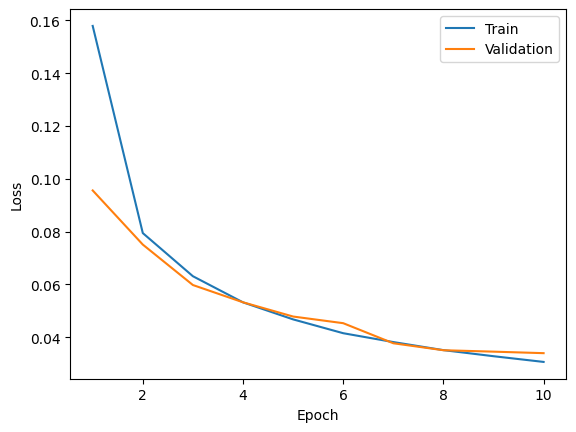

In [7]:
plt.plot(np.arange(1,11), history.history['loss'], label='Train')
plt.plot(np.arange(1,11), history.history['val_loss'], label='Validation')
plt.gca().set_ylabel('Loss')
plt.gca().set_xlabel('Epoch')
plt.gca().legend();

## Single Input Comparison

Do the categories actually help in this case? Let's try a model without them and see.

In [8]:
conv_1_A = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(img_input)
pool_1_A = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1_A)
conv_2_A = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(pool_1_A)
pool_2_A = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2_A)
features_A = tf.keras.layers.Flatten()(pool_2_A)
pred_A = tf.keras.layers.Dense(1, name='artist')(features_A)

model_A = tf.keras.Model(inputs=img_input, outputs={'artist' : pred_A})

In [9]:
model_A.compile( optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'] )

history_A = model_A.fit( x = X_img_train,
                         y = y_train,
                         validation_data = ( X_img_test, y_test ),
                         epochs=10,
                         batch_size=50,
                       )

Epoch 1/10
2400/2400 [==============================] - 11s 4ms/step - loss: 0.1619 - accuracy: 0.9338 - val_loss: 0.1030 - val_accuracy: 0.9629
Epoch 2/10
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0973 - accuracy: 0.9635 - val_loss: 0.0876 - val_accuracy: 0.9696
Epoch 3/10
2400/2400 [==============================] - 8s 3ms/step - loss: 0.0864 - accuracy: 0.9678 - val_loss: 0.0833 - val_accuracy: 0.9691
Epoch 4/10
2400/2400 [==============================] - 10s 4ms/step - loss: 0.0792 - accuracy: 0.9702 - val_loss: 0.0766 - val_accuracy: 0.9728
Epoch 5/10
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0733 - accuracy: 0.9727 - val_loss: 0.0796 - val_accuracy: 0.9740
Epoch 6/10
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0701 - accuracy: 0.9737 - val_loss: 0.0790 - val_accuracy: 0.9684
Epoch 7/10
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0661 - accuracy: 0.9754 - val_loss: 0.0672 - val_accurac

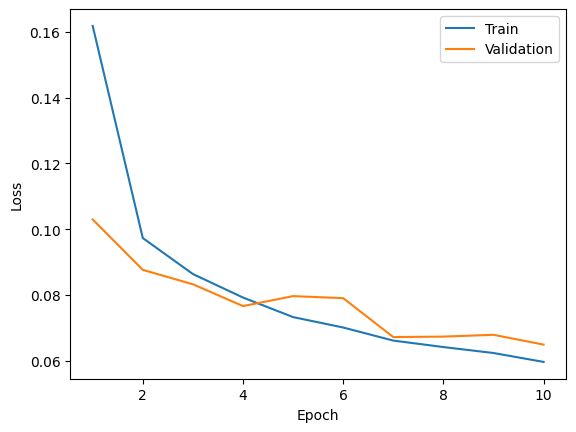

In [10]:
plt.plot(np.arange(1,11), history_A.history['loss'], label='Train')
plt.plot(np.arange(1,11), history_A.history['val_loss'], label='Validation')
plt.gca().set_ylabel('Loss')
plt.gca().set_xlabel('Epoch')
plt.gca().legend();

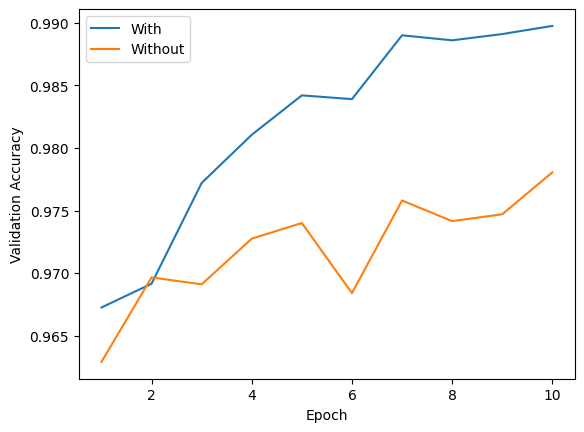

In [11]:
plt.plot(np.arange(1,11), history.history['val_accuracy'], label='With')
plt.plot(np.arange(1,11), history_A.history['val_accuracy'], label='Without')
plt.gca().set_ylabel('Validation Accuracy')
plt.gca().set_xlabel('Epoch')
plt.gca().legend();

This is hardly a conclusive experiment, and the image only model is still doing pretty well, but on this evidence I'd say the categories are indeed helping.